# Cox Communications Network Visualization

In [1]:
# Imports
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import networkx as nx

# from folium.plugins import MarkerCluster

In [2]:
# Read Files on Network Topology
pd_net_raw = pd.read_csv('network_parent_child.csv')
pd_dev_raw = pd.read_csv('device_geo_data.csv')
pd_dev_unique = pd.read_csv('devices.csv')

## Preliminary Network Analysis

<AxesSubplot:xlabel='device_type', ylabel='count'>

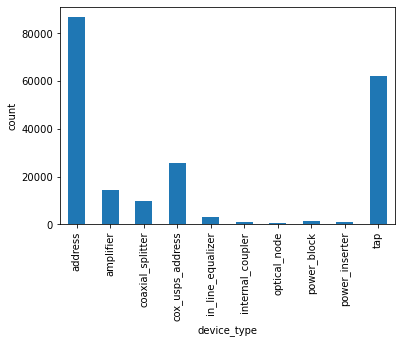

In [3]:
# Stats on number of devices, by type
pd_net_raw.groupby('device_type').count().rename(columns={'geo_id':'count'}) \
    ['count'].plot.bar(ylabel = 'count')

In [4]:
# Join tables for tail -> head information in directed graph
pd_links = pd_net_raw.merge(pd_net_raw, left_on='parent_id', right_on='geo_id', how='left', suffixes=['_tail','_head'])
pd_links.head()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
0,950351437,950351423.0,-83.759581,32.658571,tap,950351423.0,950351405.0,-83.759581,32.658571,amplifier
1,953550857,953550852.0,-83.586641,32.539248,tap,953550852.0,953550841.0,-83.586641,32.539248,in_line_equalizer
2,933436770,933436754.0,-83.713820,32.831317,tap,933436754.0,933436593.0,-83.713509,32.831229,tap
3,950348326,950348313.0,-83.754149,32.656190,tap,950348313.0,950348305.0,-83.754246,32.656532,tap
4,931035183,931035168.0,-83.690723,32.874315,tap,931035168.0,931035141.0,-83.690723,32.874315,amplifier


In [5]:
# Creating Imputation Table
pd_links_fill = pd_links[['geo_id_head','parent_id_head','lon_head','lat_head','device_type_head']]
pd_links_fill.columns = ['geo_id_tail','parent_id_tail','lon_tail','lat_tail','device_type_tail']
pd_links_fill['lat_tail'] = pd_links_fill.lat_tail + 0.0001
pd_links_fill['lon_tail'] = pd_links_fill.lon_tail + 0.0001
pd_links_fill.head()

C:\Users\MYShaw\AppData\Local\Temp/ipykernel_11100/3380189323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_links_fill['lat_tail'] = pd_links_fill.lat_tail + 0.0001
C:\Users\MYShaw\AppData\Local\Temp/ipykernel_11100/3380189323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_links_fill['lon_tail'] = pd_links_fill.lon_tail + 0.0001


,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail
0,950351423.0,950351405.0,-83.759481,32.658671,amplifier
1,953550852.0,953550841.0,-83.586541,32.539348,in_line_equalizer
2,933436754.0,933436593.0,-83.713409,32.831329,tap
3,950348313.0,950348305.0,-83.754146,32.656632,tap
4,931035168.0,931035141.0,-83.690623,32.874415,amplifier


In [6]:
# Imputing location where the geo_id exists but lat/lon is missing, and lat/lon is available for the parent
pd_links = pd_links.fillna(pd_links_fill[['lon_tail','lat_tail']])
pd_links.head()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
0,950351437,950351423.0,-83.759581,32.658571,tap,950351423.0,950351405.0,-83.759581,32.658571,amplifier
1,953550857,953550852.0,-83.586641,32.539248,tap,953550852.0,953550841.0,-83.586641,32.539248,in_line_equalizer
2,933436770,933436754.0,-83.713820,32.831317,tap,933436754.0,933436593.0,-83.713509,32.831229,tap
3,950348326,950348313.0,-83.754149,32.656190,tap,950348313.0,950348305.0,-83.754246,32.656532,tap
4,931035183,931035168.0,-83.690723,32.874315,tap,931035168.0,931035141.0,-83.690723,32.874315,amplifier


In [7]:
# All terminating nodes are either optical nodes or cox USPS nodes (with no indicated parent or no information for the parent)
pd_links[pd_links.geo_id_head.isna()].groupby('device_type_tail').count()

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head
device_type_tail,,,,,,,,,
cox_usps_address,1165,1129,1165,1165,0,0,0,0,0
optical_node,449,0,449,449,0,0,0,0,0


In [8]:
G = nx.DiGraph()
# Filter links to only those valid. Terminating nodes are either optical nodes or cox USPS nodes
G.add_edges_from(pd_links[~pd_links.geo_id_head.isna()][['parent_id_tail','geo_id_tail']].to_numpy().astype(int).tolist())
G.add_nodes_from(pd_links.geo_id_tail.to_numpy())

In [9]:
ls_subgraphs = list(nx.weakly_connected_components(G))
ls_lengths = np.array([len(i) for i in ls_subgraphs])
# 1614 Connected Subgraphs Exist, with valid connections based on parent-child relationships
len(ls_subgraphs)

1614

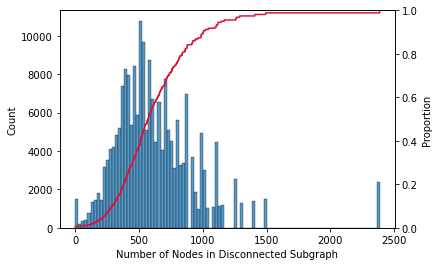

In [10]:
# Plotting CDF against
fig, ax = plt.subplots()
sns.histplot(x=ls_lengths, weights=ls_lengths, bins=100, ax=ax)
ax2 = ax.twinx()
sns.ecdfplot(x=ls_lengths, weights=ls_lengths, ax=ax2, color='crimson')
ax.set_xlabel('Number of Nodes in Disconnected Subgraph')
plt.show()

In [11]:
# Testing for if every disconnected subgraph is a tree
ls_is_tree = [nx.algorithms.tree.recognition.is_tree(G.subgraph(graph)) for graph in ls_subgraphs]

# True, every disconnected subgraph is a tree (no subgraph is not a tree)
False in ls_is_tree

False

In [12]:
# Graph Testing
G_test = G.subgraph(ls_subgraphs[1])
len(G_test.nodes())

272

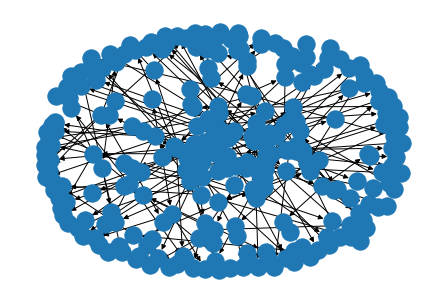

In [13]:
# Draw Graph
nx.draw_spring(G_test)

## Least Common Ancestor Search

In [14]:
# Finding a single subgraph with all search nodes common to
def find_subgraph(searchlist, graph):
    assert isinstance(searchlist, list)
    assert isinstance(graph, nx.DiGraph)
    
    searchlist = set(searchlist)
    
    # Find all subgraphs
    ls_subgraphs = list(nx.weakly_connected_components(graph))

    # Check if all points exist in each subgraph, if true, return subgraph nodes
    for graph_nodes in ls_subgraphs:
        if searchlist.issubset(graph_nodes):
            return G.subgraph(graph_nodes)
    
    # Otherwise, Nodes are from disconnected subgraphs (and cannot have an LCA)
    raise AssertionError('Nodes are from disconnected subgraphs')

In [15]:
# Finding an LCA, recursively presumes graph is a tree
def find_LCA(searchlist, graph):
    assert isinstance(searchlist, list)
    assert isinstance(graph, nx.DiGraph)
    assert nx.algorithms.tree.recognition.is_tree(graph)

    searchlist = list(set(searchlist))
    
    # Recursion: return LCA if the search list only has 1 points
    if len(searchlist) == 1:
        lca, = searchlist
        return lca
    # Otherwise, recursively find the LCA of the first two elements in the search list
    else:
        ((a,b),lca) = list(nx.algorithms.lowest_common_ancestors.tree_all_pairs_lowest_common_ancestor(graph, pairs=[(searchlist[0], find_LCA(searchlist[1:], graph))]))[0]
        return lca

In [16]:
# Find all points that 
def find_LCA_paths(searchlca, searchlist, graph):
    assert isinstance(searchlca, int)
    assert isinstance(searchlist, list)
    assert isinstance(graph, nx.DiGraph)
    assert nx.algorithms.tree.recognition.is_tree(graph)

    # Find all paths
    dict_paths = nx.algorithms.shortest_paths.generic.shortest_path(graph,source=searchlca)
    
    # Generate a set of all points connecting the LCA with the searchlist (including themselves)
    ls_nodes_LCA = set()
    for n in searchlist:
        ls_nodes_LCA.update(set(dict_paths[n]))
    return ls_nodes_LCA

#### Define Search Nodes Here

In [17]:
# Nodes to Search for LCA
ls_nodes_find=[950351872, 950353879, 950353817, 950353691, 950350208]

In [18]:
# Subgraph that all points are common to, to find LCA
search_graph = find_subgraph(searchlist=ls_nodes_find, graph=G)

# LCA Node
pt_LCA = find_LCA(searchlist=ls_nodes_find, graph=search_graph)

# List of Nodes (with 1 implicit parent) that form a minimum spanning tree between search nodes and LCA node
ls_nodes_LCA = find_LCA_paths(searchlca=pt_LCA, searchlist=ls_nodes_find, graph=search_graph)

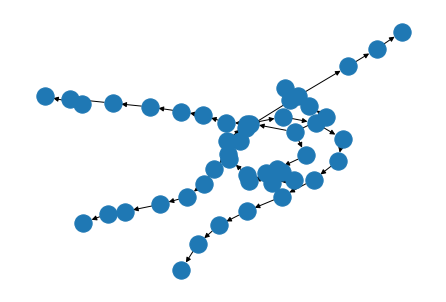

In [19]:
# Draw Minimum Spanning Tree
nx.draw_spring(G.subgraph(ls_nodes_LCA))

## Graphing/Mapping Pre-Processing

In [20]:
# Create DF for plotting
pd_links_plot_all = pd_links[pd_links.geo_id_tail.isin(list(search_graph.nodes()))]
pd_links_plot_lca = pd_links[pd_links.geo_id_tail.isin(ls_nodes_LCA)]

In [21]:
# Unique Device Types
ls_device_types = list(pd_net_raw.device_type.unique())
print(ls_device_types)

['tap', 'amplifier', 'cox_usps_address', 'power_inserter', 'in_line_equalizer', 'power_block', 'coaxial_splitter', 'internal_coupler', 'optical_node', 'address']


In [22]:
# Plot Settings
dict_device_icons = {
    'address':              {'color': 'lightblue', 'icon': 'home', 'angle': 0},
    'tap':                  {'color': 'blue', 'icon': 'exchange', 'angle': 0},
    
    'amplifier':            {'color': 'green', 'icon': 'bolt', 'angle': 45},
    'power_inserter':       {'color': 'darkgreen', 'icon': 'bolt', 'angle': 45},
    'power_block':          {'color': 'lightgreen', 'icon': 'bolt', 'angle': 45},
    
    'in_line_equalizer':    {'color': 'gray', 'icon': 'arrows', 'angle': -45},
    'coaxial_splitter':     {'color': 'beige', 'icon': 'arrows', 'angle': -45},
    'internal_coupler':     {'color': 'lightgray', 'icon': 'arrows', 'angle': -45},
    
    'cox_usps_address':     {'color': 'cadetblue', 'icon': 'server', 'angle': 0},
    'optical_node':         {'color': 'darkpurple', 'icon': 'server', 'angle': 0}
    }

ls_disperse_pt = ['amplifier', 'cox_usps_address', 'power_inserter', 'in_line_equalizer', 'power_block', 'coaxial_splitter', 'internal_coupler', 'optical_node']

In [23]:
# Find the "Network Node" (Cox Communications terminally, really a "neighborhood") common to all points in the subgraph
pd_find_node = pd_links_plot_all.merge(pd_dev_raw, left_on='geo_id_tail', right_on='geo_id').groupby('node').count()
display(pd_find_node)
print('Mapping for node {}'.format(pd_find_node.index[0]))

,geo_id_tail,parent_id_tail,lon_tail,lat_tail,device_type_tail,geo_id_head,parent_id_head,lon_head,lat_head,device_type_head,geo_id,mac
node,,,,,,,,,,,,
WR063,56,56,56,56,56,56,56,56,56,56,56,56


Mapping for node WR063


## Mapping LCA Network

In [24]:
# Define points to plot
pt_net_link_plot = pd_links_plot_all
pd_net_pt_plot = pd_links_plot_lca

# Start at mean location
startloc = [pd_net_pt_plot.lat_tail.mean(), pd_net_pt_plot.lon_tail.mean()]
my_map = folium.Map(location = startloc, zoom_start = 15)

# Create Base Connections Feature Group
feature_group_pl = folium.FeatureGroup("Local Subnetwork")
# Define Links to plot (Filter out links that are missing coordinates)
pd_net_pl_plot = pt_net_link_plot[~pt_net_link_plot.isna()[['lon_tail','lat_tail','lon_head','lat_head']].any(axis=1)]
# Plot connetions as polylines
for lat_tail, lng_tail, name, lat_head, lng_head in pd_net_pl_plot[['lat_tail','lon_tail','device_type_tail','lat_head','lon_head']].to_numpy():
    feature_group_pl.add_child(folium.vector_layers.PolyLine(locations=[(lat_tail,lng_tail),(lat_head,lng_head)]))

# Create Point Feature Groups
for name in ls_device_types:
    globals()['feature_group_{}'.format(name)] = folium.FeatureGroup(name)
# Go through every group of point features
for name, iconsetting in dict_device_icons.items():
    # Filter features from df
    pd_pt_filter = pd_net_pt_plot[pd_net_pt_plot.device_type_tail == name]
    # Define parameters
    for lat, lng, id, name in pd_pt_filter[['lat_tail','lon_tail','geo_id_tail','device_type_tail']].to_numpy():
        if name in ls_disperse_pt:
            # Horizontal dispersion for certain features (overlapping)
            dispersion = np.random.uniform(-0.000025, 0.000025)
            dispersion = dispersion + 0.000025 if dispersion >= 0 else dispersion - 0.000025
            lng += dispersion
        # Plot points
        globals()['feature_group_{}'.format(name)].add_child(folium.Marker(location=[lat,lng],popup='ID={}\nDevice={}'.format(str(id),name),icon=folium.Icon(
            icon=iconsetting['icon'], color=iconsetting['color'], prefix='fa')))

# Create LCA Connections Feature Group
feature_group_LCA_pl = folium.FeatureGroup("LCA connections")
# Define Links to plot (Filter out links that are missing coordinates)
pd_net_LCA_pl_plot = pd_net_pt_plot[~pd_net_pt_plot.isna()[['lon_tail','lat_tail','lon_head','lat_head']].any(axis=1)]
# Plot connetions as polylines
for lat_tail, lng_tail, name, lat_head, lng_head in pd_net_LCA_pl_plot[['lat_tail','lon_tail','device_type_tail','lat_head','lon_head']].to_numpy():
    feature_group_LCA_pl.add_child(folium.vector_layers.PolyLine(locations=[(lat_tail,lng_tail),(lat_head,lng_head)],color='red'))

# Create LCA Points feature froup
feature_group_pt_lca = folium.FeatureGroup("LCA points")
pd_pt_LCA_filter = pd_net_pt_plot[pd_net_pt_plot.geo_id_tail.isin(ls_nodes_find + [pt_LCA])]
for name, iconsetting in dict_device_icons.items():
    pd_pt_filter = pd_pt_LCA_filter[pd_pt_LCA_filter.device_type_tail == name]
    # Define parameters
    for lat, lng, id, name in pd_pt_filter[['lat_tail','lon_tail','geo_id_tail','device_type_tail']].to_numpy():
        # Plot points
        if id == pt_LCA:
            feature_group_pt_lca.add_child(folium.Marker(location=[lat,lng],popup='LCA-Device:\nID={}\nDevice={}'.format(str(id),name),icon=folium.Icon(
                icon=iconsetting['icon'], color='pink', prefix='fa')))
        else:
            feature_group_pt_lca.add_child(folium.Marker(location=[lat,lng],popup='TargetDevice:\nID={}\nDevice={}'.format(str(id),name),icon=folium.Icon(
                icon=iconsetting['icon'], color='red', prefix='fa')))

# Add Feature Groups
my_map.add_child(feature_group_pl)
for name in dict_device_icons.keys():
    my_map.add_child(globals()['feature_group_{}'.format(name)])

my_map.add_child(feature_group_LCA_pl)
my_map.add_child(feature_group_pt_lca)

my_map.add_child(folium.map.LayerControl('topright', collapsed= False))

# Show
my_map